In [1]:
import visa                             # Import PyVISA library
import time
from struct import *                    # Import Struct module (interpret strings as packed binary data)
import numpy as np
#import VISAresourceExtentions

In [2]:
# Initialization

rm = visa.ResourceManager()             # Create Resource Manager object
rs = rm.list_resources()                # Method to list the available resources
print(rs[0])                            
counter = rm.open_resource(rs[0])       # Assign the returned object to the instrument variable (i.e. counter)

USB0::5355::145::457158::0::INSTR


In [3]:
# Initial settings

print(counter.query('*IDN?'))           # Query the Identification string 
counter.write('*RST;*CLS')              # Reset the instrument, clear the Error queue
counter.timeout = 1e7                   # Acquisition timeout (ms) - set it higher than the acquisition time
counter.query('SYST:ERR?')              # Error Checking 

PENDULUM, CNT-91, 457158, V1.31 06 Mar 2015 12:55



'0,"No error"\n-'

In [4]:
#Basic settings

counter.write("FUNC 'FREQ:BTB 1'")                                 # Setup for frequency back-to-back measurement from channel A (1) - Set up for period back-to-back is "FUNC 'PER:BTB 1'" 
counter.write('CALC:AVER:STAT OFF')                                # Enable/disable statitics; 
counter.write('INP:LEV:AUTO OFF; :INP:LEV 0')                      # Enable/Disable autotrigger on channel A; Trigger level (V)
counter.write('CAL:INT:AUTO OFF; :DISP:ENAB ON')                   # Enable/Disable reciprocal counter that uses an interpolating technique to increase the resolution; Enable/Disable the display (if OFF increase the GPIB speed)

counter.write('FORMAT:TINF ON; :FORMAT PACKED')                    # Read timestamp of each measurement; Redout in ASCII/REAL/PACKED mode - Readout format: ASCII/REAL -> [freq (Hz), tstamp (sec)] ; PACKED -> [freq (Hz), tstamp (picosec)] 
counter.write('SENSE:ACQ:APER 4e-6')                               # Gate time (sec), minimum: 4 microsec
counter.write('TRIG:COUNT 1; :ARM:COUNT 1e5')                      # Measure N samples inside one block (Triggerings); Number of blocks (Armings), with CNT-91 it can be set to INF (non-stop continuous measurements)
counter.query('SYST:ERR?')                                         # Error Checking 
#time.sleep(1)                                                      # Wait (sec)

'0,"No error"\n-'

In [5]:
#counter.write('*ESE 0;*SRE 0')                      # To be developed
#counter.wait_on_event(counter, RQS, 10000)
#counter.last_status
#counter.query('*ESR?')
#counter.read()
#counter.query('SYST:ERR?')

In [6]:
# Perform  M ('ARM:COUNT') block measurements of 1 ('TRIG:COUNT') sample each (Zero Dead time between samples/blocks)
# Fetch the data of one acquisiton ( Total number of samples/measurements = M ) over multiple cycles 

#counter.write('INIT:CONT ON')               # Initialize infinite continuous acquisition ( only if ':ARM:COUNT' is set to INF ) - Arm loop will continue endlessly for 107 days
counter.query('INIT;*OPC?')                  # Initialize acquisition; *OPC? query waits until the acquisition ends

start = time.time()

for i in range(10):
    
    # Read Data in BINARY format (packed)
    
    #counter.write('FETCH:ARR? 1000')                                                              
    #counter.query_binary_values(datatype='s', is_big_endian=True)                                  
    bytesvalues = counter.query_binary_values('FETCH:ARR? 1e4', datatype='s', is_big_endian=True)   # Fetch Binary values - Rate = 7,313*10^3 Samples/s (Maximum fetchable samples = 1e4)
    freqtimelist = unpack('>'+'dQ'*int(1e4), bytesvalues[0])                                        # Convert (unpack) into a readable format - Readout format (tuple) -> (freq [Hz], timestamps [ps], freq, tstamp, ...)
    #print(bytesvalues) 
    
    # Read Data in ASCII format
    
    #freqtimelist = counter.query_ascii_values('FETCH:ARR? 1e4', converter = 's')  # Fetch and Convert list of ASCII values into a list of strings (Maximum Fetchable samples = 1e4)
    
    #if  freqtimelist[-1] == '' :    del freqtimelist[-1]                          # Delete the last element of the list when it is an empty string = ''
    #freqtimelist[-1] = freqtimelist[-1].split('\n')[0]                            # Delete in the last element of the list of strings every character after the number ( i.e. \n0E..)
    #freqtimelist = [float(i) for i in freqtimelist]                               # Convert list of strings into float numbers
        
    print(freqtimelist)
    
    if (i==0): freqtimeList = freqtimelist                                        # Create a bigger List appending all the fetched data lists during the loop     
    else:  freqtimeList = freqtimeList + freqtimelist 
           
    end = time.time() 
    print(end-start)                                                              # Single acquisition time (sec)
    
#print(len(freqtimeList))                                                         # Number of elements of the Big List
                                                
end = time.time()
print(end-start)                                                                  # Total acquisition time (sec)
#counter.query('SYST:ERR?')                                                       # Error Checking 

(38837989.54592287, 5150896788151, 38839131.64579156, 5150898590457, 38838414.362287104, 5150901113732, 38837948.65921941, 5150905130422, 38838625.511001796, 5150909147042, 38838799.56241619, 5150913163644, 38838122.704567365, 5150917180316, 38838113.035340436, 5150921196989, 38839312.056195505, 5150925213538, 38839138.000187725, 5150929230105, 38838287.08216165, 5150933246760, 38838799.56241619, 5150937263362, 38838287.08216165, 5150941280017, 38839312.056195505, 5150945296566, 38838789.89285225, 5150949313169, 38838963.94573998, 5150953329754, 38838809.23198495, 5150957346355, 38838799.56241619, 5150961362957, 38839128.33045526, 5150965379525, 38838635.180483885, 5150969396144, 38839138.000187725, 5150973412711, 38838963.94573998, 5150977429296, 38838809.23198495, 5150981445897, 38838963.94573998, 5150985462482, 38838963.94573998, 5150989479067, 38839147.669925004, 5150993495633, 38838963.94573998, 5150997512218, 38838287.08216165, 5151001528873, 38839486.11376334, 5151005545404, 388

(38838963.94573998, 5191049171901, 38838287.08216165, 5191053188556, 38839988.95550058, 5191057205035, 38838635.180483885, 5191061221654, 38838625.511001796, 5191065238274, 38839650.50289879, 5191069254788, 38838625.511001796, 5191073271408, 38838287.08216165, 5191077288063, 38840501.48066963, 5191081304489, 38838461.130542785, 5191085321126, 38838625.511001796, 5191089337746, 38839312.056195505, 5191093354295, 38839814.89342579, 5191097370792, 38838122.704567365, 5191101387464, 38840839.94810267, 5191105403855, 38838287.08216165, 5191109420510, 38839476.44385754, 5191113437042, 38838799.56241619, 5191117453644, 38839138.000187725, 5191121470211, 38839138.000187725, 5191125486778, 38839138.000187725, 5191129503345, 38839640.83291112, 5191133519860, 38839147.669925004, 5191137536426, 38839147.669925004, 5191141552992, 38839292.71656205, 5191145569543, 38839660.17289126, 5191149586056, 38839312.056195505, 5191153602605, 38839466.773956545, 5191157619138, 38839147.669925004, 5191161635704

(38839138.000187725, 5231205315176, 38839650.50289879, 5231209331690, 38839138.000187725, 5231213348257, 38839486.11376334, 5231217364788, 38839319.716704994, 5231221329842, 38839486.11376334, 5231225346373, 38839988.95550058, 5231229362852, 38838625.511001796, 5231233379472, 38839486.11376334, 5231237396003, 38839988.95550058, 5231241412482, 38839814.89342579, 5231245428979, 38839312.056195505, 5231249445528, 38839138.000187725, 5231253462095, 38839312.056195505, 5231257478644, 38839988.95550058, 5231261495123, 38839312.056195505, 5231265511672, 38839476.44385754, 5231269528204, 38839824.56350012, 5231273544700, 38839814.89342579, 5231277561197, 38839138.000187725, 5231281577764, 38840163.019135505, 5231285594225, 38839988.95550058, 5231289610704, 38838635.180483885, 5231293627323, 38840327.41400105, 5231297643767, 38839814.89342579, 5231301660264, 38839312.056195505, 5231305676813, 38839988.95550058, 5231309693292, 38839814.89342579, 5231313709789, 38839998.62566158, 5231317726267, 3

(38839138.000187725, 5271361408204, 38840675.54889842, 5271365424612, 38839814.89342579, 5271369441109, 38838973.61539059, 5271373457693, 38839650.50289879, 5271377474207, 38840153.34889264, 5271381490669, 38840163.019135505, 5271385507130, 38839312.056195505, 5271389523679, 38840327.41400105, 5271393540123, 38839138.000187725, 5271397556690, 38839312.056195505, 5271401573239, 38838615.841524504, 5271405589860, 38838132.3737991, 5271409606531, 38838287.08216165, 5271413623186, 38836914.088513814, 5271417639983, 38837791.693252064, 5271421605193, 38837600.57320315, 5271425621919, 38836082.6043477, 5271429638802, 38837262.16222473, 5271433655563, 38836759.3910894, 5271437672376, 38836740.05399801, 5271441689191, 38837107.46202739, 5271445705968, 38837436.201419905, 5271449722711, 38836749.722541295, 5271453739525, 38837107.46202739, 5271457756302, 38837948.65921941, 5271461772992, 38837252.4934263, 5271465789754, 38837107.46202739, 5271469806531, 38837948.65921941, 5271473823221, 3883793

(38837600.57320315, 5311517500880, 38836585.357960045, 5311521517711, 38838122.704567365, 5311525534383, 38837097.79330598, 5311529551161, 38836749.722541295, 5311533567975, 38838461.130542785, 5311537584612, 38837600.57320315, 5311541601338, 38837445.87030982, 5311545618080, 38838625.511001796, 5311549634700, 38837948.65921941, 5311553651390, 38836923.75714375, 5311557668186, 38837774.61543134, 5311561684894, 38838461.130542785, 5311565701531, 38838451.46114736, 5311569718169, 38838122.704567365, 5311573734841, 38838113.035340436, 5311577751514, 38837784.28448976, 5311581768221, 38838799.56241619, 5311585784823, 38838113.035340436, 5311589801496, 38837774.61543134, 5311593818204, 38839138.000187725, 5311597834771, 38837948.65921941, 5311601851461, 38837774.61543134, 5311605868169, 38838635.180483885, 5311609884788, 38838281.43126632, 5311613849948, 38838296.75147523, 5311617866602, 38838287.08216165, 5311621883257, 38838625.511001796, 5311625899877, 38837610.24217491, 5311629916602, 3

(38838296.75147523, 5351673595933, 38838799.56241619, 5351677612535, 38837774.61543134, 5351681629243, 38838635.180483885, 5351685645862, 38838287.08216165, 5351689662517, 38837600.57320315, 5351693679243, 38837948.65921941, 5351697695933, 38839312.056195505, 5351701712482, 38838277.41285288, 5351705729138, 38837958.328364484, 5351709745827, 38838973.61539059, 5351713762411, 38838103.36611834, 5351717779085, 38838296.75147523, 5351721795739, 38838461.130542785, 5351725812376, 38838441.79175674, 5351729829015, 38838132.3737991, 5351733845686, 38838287.08216165, 5351737862341, 38838789.89285225, 5351741878944, 38838973.61539059, 5351745895528, 38838635.180483885, 5351749912147, 38838451.46114736, 5351753928785, 38838635.180483885, 5351757945404, 38838451.46114736, 5351761962042, 38837774.61543134, 5351765978750, 38838799.56241619, 5351769995352, 38839312.056195505, 5351774011901, 38838122.704567365, 5351778028573, 38838625.511001796, 5351782045193, 38838963.94573998, 5351786061778, 38838

(38838461.130542785, 5391829687429, 38838799.56241619, 5391833704031, 38838113.035340436, 5391837720704, 38838799.56241619, 5391841737306, 38838973.61539059, 5391845753890, 38838799.56241619, 5391849770492, 38838113.035340436, 5391853787165, 38839312.056195505, 5391857803714, 38838451.46114736, 5391861820352, 38838122.704567365, 5391865837024, 38839138.000187725, 5391869853591, 38838963.94573998, 5391873870176, 38838461.130542785, 5391877886813, 38838799.56241619, 5391881903415, 38839128.33045526, 5391885919983, 38838470.79994304, 5391889936619, 38838625.511001796, 5391893953239, 38838789.89285225, 5391897969842, 38838635.180483885, 5391901986461, 38839486.11376334, 5391906002992, 38838780.22329311, 5391910019596, 38838809.23198495, 5391914036197, 38838461.130542785, 5391918052834, 38839640.83291112, 5391922069349, 38838635.180483885, 5391926085968, 38838625.511001796, 5391930102588, 38839138.000187725, 5391934119155, 38839650.50289879, 5391938135669, 38838461.130542785, 5391942152306,

(38838625.511001796, 5431985831003, 38838461.130542785, 5431989847640, 38839650.50289879, 5431993864154, 38838789.89285225, 5431997880757, 38838973.61539059, 5432001897341, 38839505.830339454, 5432005862376, 38838615.841524504, 5432009878997, 38839147.669925004, 5432013895563, 38839476.44385754, 5432017912095, 38838461.130542785, 5432021928732, 38838799.56241619, 5432025945334, 38839824.56350012, 5432029961830, 38838625.511001796, 5432033978450, 38839302.38637637, 5432037995000, 38839147.669925004, 5432042011566, 38839302.38637637, 5432046028116, 38839824.56350012, 5432050044612, 38838625.511001796, 5432054061232, 38838799.56241619, 5432058077834, 38839650.50289879, 5432062094348, 38838461.130542785, 5432066110985, 38839476.44385754, 5432070127517, 38839988.95550058, 5432074143996, 38838799.56241619, 5432078160598, 38838461.130542785, 5432082177235, 38840153.34889264, 5432086193697, 38839650.50289879, 5432090210211, 38838461.130542785, 5432094226848, 38839650.50289879, 5432098243362, 3

(38838799.56241619, 5472141928591, 38839476.44385754, 5472145945123, 38839824.56350012, 5472149961619, 38838963.94573998, 5472153978204, 38839988.95550058, 5472157994683, 38839138.000187725, 5472162011250, 38838635.180483885, 5472166027869, 38840163.019135505, 5472170044330, 38839302.38637637, 5472174060880, 38838625.511001796, 5472178077500, 38839486.11376334, 5472182094031, 38839988.95550058, 5472186110510, 38838986.67570556, 5472190075598, 38839312.056195505, 5472194092147, 38839138.000187725, 5472198108714, 38838451.46114736, 5472202125352, 38838635.180483885, 5472206141971, 38837774.61543134, 5472210158679, 38837774.61543134, 5472214175387, 38838625.511001796, 5472218192007, 38837610.24217491, 5472222208732, 38838287.08216165, 5472226225387, 38838461.130542785, 5472230242024, 38837436.201419905, 5472234258767, 38838287.08216165, 5472238275422, 38838113.035340436, 5472242292095, 38838122.704567365, 5472246308767, 38838287.08216165, 5472250325422, 38839312.056195505, 5472254341971, 

(38838461.130542785, 5512298025334, 38838461.130542785, 5512302041971, 38838113.035340436, 5512306058644, 38838287.08216165, 5512310075299, 38838799.56241619, 5512314091901, 38837271.83102799, 5512318108661, 38839988.95550058, 5512322125140, 38838113.035340436, 5512326141813, 38838122.704567365, 5512330158485, 38838625.511001796, 5512334175105, 38838625.511001796, 5512338191725, 38838799.56241619, 5512342208327, 38838625.511001796, 5512346224947, 38838799.56241619, 5512350241549, 38838625.511001796, 5512354258169, 38838635.180483885, 5512358274788, 38839650.50289879, 5512362291302, 38838810.362194605, 5512366256408, 38838625.511001796, 5512370273028, 38838451.46114736, 5512374289666, 38839660.17289126, 5512378306179, 38838799.56241619, 5512382322781, 38838441.79175674, 5512386339420, 38839495.783673964, 5512390355950, 38838799.56241619, 5512394372552, 38838441.79175674, 5512398389191, 38838809.23198495, 5512402405792, 38839988.95550058, 5512406422271, 38838461.130542785, 5512410438908,

In [7]:
# Overlapping ADEV calculation

start = time.time()

freqtimearray = np.array(freqtimeList)                     # Convert list to numpy array
freqarray=(freqtimearray[::2])                             # Take the elements of the array at even steps
timearray=(freqtimearray[1::2])                            # Take the elements of the array at odd steps
 
StepSize = (timearray[2:]-timearray[1:-1]).mean()          # Calculate the mean time delay between two consecutive frequency samples
StepSize *= 1e-12                                          # From psec -> sec (only if data are taken in PAKED form)
#print(StepSize)

freqmean = freqarray.mean()                                # Calculate the mean frequency over all the frequency samples
#print(freqmean)

Taulist = []                                               # Define list: list=[] ; Define numpy array:  arr=np.array([])
Adevlist = [] 
Sampleslist = []

for i in range(4):
    
    x = i-5    # [-5,-4,-3,-2,-1,0,+1]
    
    for y in [0,1,2,3,4]:                                  # Iterations - NotEvenlySpaced: [1,2,4,6,8] - EvenlySpaced: [0,1,2,3,4]
        
        tau = (10**x)*10**(y/5)                            # Gate time (sec) - NotEvenlySpaced: y*10**(x) - EvenlySpaced: (10**x)*10**(y/5) 
        Tratio = int(round(tau/StepSize))                  # Take the nearest integer to the Tratio (i.e. Number of freq samples inside a specific Gate time)
        #print(Tratio)
        
        freqarr = freqarray[::Tratio]                                                                   # Define an array with number of elements = Tratio
        freqarr = np.array( [freqarray[Tratio*i:Tratio*(i+1)].mean() for i in range(len(freqarr))] )    # Average all the freq samples (# = Tratio) inside a specific Gate time
        #print(len(freqarr))
        
        print(f'Gate time = {tau} s, Samples = {len(freqarr)}') 
                
        deltafreqarray = (freqarr[1:]-freqarr[:-1])**2      # Calculate the square of all the differences of consecutive pairs of frequencies
        #print(len(deltafreqarray))
        adev = (np.mean(deltafreqarray)/2)**(1/2)           # Calculate Adev
        print(adev)
        #print(adev/freqmean)
        
        Taulist.append(tau)                                                   # Append a value to the list at each iteration
        Adevlist.append(adev)
        Sampleslist.append(len(freqarr))                                      # Creating the Samples array for each Gate time (append the number of samples value at each iteration)
         
        #end = time.time()     
        #print(end-start)                                                      # Acquisition time for each Gate time (sec)

end = time.time()
print(end-start)                                                              # Total acquisition time (sec)

Gate time = 1e-05 s, Samples = 50000
301.7475940588544
Gate time = 1.5848931924611138e-05 s, Samples = 25000
260.2608742753795
Gate time = 2.5118864315095805e-05 s, Samples = 16667
301.33848725942573
Gate time = 3.981071705534973e-05 s, Samples = 10000
393.93951650287636
Gate time = 6.309573444801933e-05 s, Samples = 6250
462.2122039661385
Gate time = 0.0001 s, Samples = 4000
489.9783415333189
Gate time = 0.00015848931924611136 s, Samples = 2565
490.20221502795226
Gate time = 0.000251188643150958 s, Samples = 1588
402.20043454434017
Gate time = 0.00039810717055349724 s, Samples = 1011
272.60609624025
Gate time = 0.0006309573444801934 s, Samples = 637
160.7631488918718
Gate time = 0.001 s, Samples = 402
65.448594995544
Gate time = 0.0015848931924611136 s, Samples = 254
48.9989717612834
Gate time = 0.0025118864315095803 s, Samples = 160
23.096145810940985
Gate time = 0.0039810717055349725 s, Samples = 101
28.903444105028754
Gate time = 0.006309573444801934 s, Samples = 64
18.530896235533

In [8]:
print(Taulist)  
print(Adevlist)
print(Sampleslist)

[1e-05, 1.5848931924611138e-05, 2.5118864315095805e-05, 3.981071705534973e-05, 6.309573444801933e-05, 0.0001, 0.00015848931924611136, 0.000251188643150958, 0.00039810717055349724, 0.0006309573444801934, 0.001, 0.0015848931924611136, 0.0025118864315095803, 0.0039810717055349725, 0.006309573444801934, 0.01, 0.015848931924611138, 0.0251188643150958, 0.03981071705534972, 0.06309573444801933]
[301.7475940588544, 260.2608742753795, 301.33848725942573, 393.93951650287636, 462.2122039661385, 489.9783415333189, 490.20221502795226, 402.20043454434017, 272.60609624025, 160.7631488918718, 65.448594995544, 48.9989717612834, 23.096145810940985, 28.903444105028754, 18.530896235533227, 15.651680726523779, 8.821339189554651, 4.065247939870415, 5.335815634318249, 2.7029509599378514]
[50000, 25000, 16667, 10000, 6250, 4000, 2565, 1588, 1011, 637, 402, 254, 160, 101, 64, 41, 26, 16, 11, 7]


array([50000, 25000, 16667, 10000,  6250,  4000,  2565,  1588,  1011,
         637,   402,   254,   160,   101,    64,    41,    26,    16,
          11,     7])
array([1.00000000e-05, 1.58489319e-05, 2.51188643e-05, 3.98107171e-05,
       6.30957344e-05, 1.00000000e-04, 1.58489319e-04, 2.51188643e-04,
       3.98107171e-04, 6.30957344e-04, 1.00000000e-03, 1.58489319e-03,
       2.51188643e-03, 3.98107171e-03, 6.30957344e-03, 1.00000000e-02,
       1.58489319e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02])
array([301.74759406, 260.26087428, 301.33848726, 393.9395165 ,
       462.21220397, 489.97834153, 490.20221503, 402.20043454,
       272.60609624, 160.76314889,  65.448595  ,  48.99897176,
        23.09614581,  28.90344411,  18.53089624,  15.65168073,
         8.82133919,   4.06524794,   5.33581563,   2.70295096])
array([7.76923308e-06, 6.70105556e-06, 7.75869962e-06, 1.01429406e-05,
       1.19007887e-05, 1.26156961e-05, 1.26214603e-05, 1.03556382e-05,
       7.01891363e-06, 4

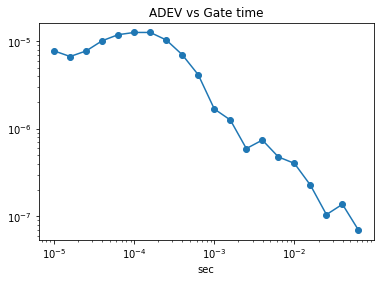

In [10]:
# ADEV vs Gate time plot

import matplotlib.pyplot as plt
import pandas as pd

# Convert lists to numpy arrays

TauArray = np.array(Taulist)      
AdevArray = np.array(Adevlist)
SamplesArray = np.array(Sampleslist)

print(repr(SamplesArray))
print(repr(TauArray))
print(repr(AdevArray))

ADEVArray = AdevArray/freqmean   # Calculate normalized Adev

print(repr(ADEVArray))

plt.plot(TauArray, ADEVArray, 'o-')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.show()

In [11]:
counter.write('*RST;*CLS') 

(24, <StatusCode.success: 0>)

In [ ]:
counter.close()